In [1]:
using Revise

In [2]:
using Distributed
procs_to_use = 1

if nprocs() <= procs_to_use
    addprocs(procs_to_use-nprocs())
end

@everywhere using
    QuantumStates,
    OpticalBlochEquations,
    DifferentialEquations,
    UnitsToValue,
    LinearAlgebra,
    Printf,
    Plots,
    Random,
    StatsBase,
    Distributions,
    StructArrays,
    StaticArrays,
    StructArrays,
    LoopVectorization,
    Parameters,
    MutableNamedTuples

@everywhere @consts begin
    λ = 687e-9
    Γ = 2π * 6.4e6
    m = @with_unit 105 "u"
    k = 2π / λ
    _μB = (μB / h) * 1e-4
    kB = 1.380649e-23
end
;

[ Info: Precompiling OpticalBlochEquations [691d0331-80d3-41b1-b293-7891a6f4a14f]
  ** incremental compilation may be fatally broken for this module **



In [3]:
@everywhere begin
    Isat = π*c*h*Γ/(3*λ^3) # saturation intensity in mW/cm^2
    P = 2.5 * 13.6e-3 # power in mW, converting from voltage (1 V = 13.6 mW)
    I = 2P / (π * (5e-3)^2)
    s = I/Isat
end

In [4]:
const RF_frequency = 2π * 1.4e6 / Γ
;

In [6212]:
@everywhere sim_params = MutableNamedTuple(

    # Notes:
    # B-field gradient should be given in amplitude, not RMS
    
    pol_imbalance = 0.0,
    s_imbalance = (0.0, 0.0, 0.0),
    retro_loss = 0.0,
    off_center = (0,0,0,0,0,0) .* 1e-3,
    pointing_error = (0,0,0,0,0,0),

    ### 2-FREQUENCY RF MOT ###
    RF_frequency = 2π * 1.4e6 / Γ,
    B_gradient = +5.0 * √2,
    B_offset = (0e-3, 0e-3, 0e-3),
    s1 = s/20,
    s2 = s/20,
    s3 = s/8,
    s4 = s/8,
    Δ1 = -2Γ,
    Δ2 = -2Γ,
    Δ3 = -4Γ,
    Δ4 = -4Γ,
    pol1_x = [1,0,0],
    pol2_x = [0,0,1],
    pol3_x = [1,0,0],
    pol4_x = [0,0,1],

    # slowing lasers parameters
    s5 = 0 * 3s,
    s6 = 0 * 3s,
    Δ5 = -6Γ,
    Δ6 = -6Γ,
    pol5_x = [1,0,0],
    pol6_x = [0,0,1]
)
;

### Calculate transition dipole moments

In [6213]:
@everywhere begin
    include("define_SrOH_states.jl")
    X_states, A_states = define_CaOH_states()
    states = [X_states; A_states[1:4]]
    d = tdms_between_states(states, states)
end
;

### Define lasers

In [6214]:
@everywhere begin
    include("define_lasers.jl")
    lasers = define_lasers(
        states,
        sim_params.RF_frequency,
        sim_params.s1,
        sim_params.s2,
        sim_params.s3,
        sim_params.s4,
        sim_params.Δ1,
        sim_params.Δ2,
        sim_params.Δ3,
        sim_params.Δ4,
        sim_params.pol1_x,
        sim_params.pol2_x,
        sim_params.pol3_x,
        sim_params.pol4_x,
        sim_params.pol_imbalance,
        sim_params.s_imbalance,
        sim_params.retro_loss,
        sim_params.off_center,
        sim_params.pointing_error,
        sim_params.s5,
        sim_params.s6,
        sim_params.Δ5,
        sim_params.Δ6,
        sim_params.pol5_x,
        sim_params.pol6_x
    )
end
;

In [6215]:
@everywhere begin
    
    # J=1/2 components
    ϵJ12 = σ⁻
    s1 = s/32
    s2 = s/16
    s3 = s/2
    s4 = 0s/4
    ω1 = 2π * (energy(states[end]) - energy(states[1])) - 1Γ
    ω2 = 2π * (energy(states[end]) - energy(states[1])) - 2Γ
    ω3 = 2π * (energy(states[end]) - energy(states[1])) - 3Γ
    ω4 = 2π * (energy(states[end]) - energy(states[1])) - 4Γ
    
    # J=3/2 components
    ϵJ32 = σ⁺
    s5 = s/32
    s6 = s/16
    s7 = s/2
    s8 = 0s/4
    ω5 = 2π * (energy(states[end]) - energy(states[5])) - 1Γ
    ω6 = 2π * (energy(states[end]) - energy(states[5])) - 2Γ
    ω7 = 2π * (energy(states[end]) - energy(states[5])) - 3Γ
    ω8 = 2π * (energy(states[end]) - energy(states[5])) - 4Γ
    
    lasers_tuple1 = [
        (ω1, ϵJ12, s1),
        (ω2, ϵJ12, s2),
        (ω3, ϵJ12, s3),
        (ω4, ϵJ12, s4),
        (ω5, ϵJ32, s5),
        (ω6, ϵJ32, s6),
        (ω7, ϵJ32, s7),
        (ω8, ϵJ32, s8)
    ]

    include("define_lasers_updated.jl")
    lasers1 = define_lasers(
        sim_params.RF_frequency,
        lasers_tuple1
    )
    
    ## Define a "slowing" beam going against x + y
    # J=1/2 components
    s1 = s/4
    s2 = s/4
    s3 = s/4
    s4 = s/4
    ω1 = 2π * (energy(states[end]) - energy(states[1])) - 5Γ
    ω2 = 2π * (energy(states[end]) - energy(states[1])) - 7Γ
    ω3 = 2π * (energy(states[end]) - energy(states[1])) - 9Γ
    ω4 = 2π * (energy(states[end]) - energy(states[1])) - 11Γ

    # J=3/2 components
    s5 = s/4
    s6 = s/4
    s7 = s/4
    s8 = s/4
    ω5 = 2π * (energy(states[end]) - energy(states[5])) - 5Γ
    ω6 = 2π * (energy(states[end]) - energy(states[5])) - 7Γ
    ω7 = 2π * (energy(states[end]) - energy(states[5])) - 9Γ
    ω8 = 2π * (energy(states[end]) - energy(states[5])) - 11Γ
    
    lasers_tuple2 = [
        (ω1, ϵJ32, s1),
        (ω2, ϵJ32, s2),
        (ω3, ϵJ32, s3),
        (ω4, ϵJ32, s4),
        (ω5, ϵJ12, s5),
        (ω6, ϵJ12, s6),
        (ω7, ϵJ12, s7),
        (ω8, ϵJ12, s8)
    ]
    
    include("define_lasers_updated3.jl")
    lasers2 = define_lasers(
        sim_params.RF_frequency,
        lasers_tuple2
    )
    
    # lasers = lasers1
    lasers = [lasers1; lasers2]
    lasers = convert(Vector{Field{Float64, typeof(lasers[1].ϵ), typeof(lasers[1].s_func)}}, lasers)
    
end

In [7470]:
@everywhere begin
  
    ωJ12 = 2π * (energy(states[end]) - energy(states[1]))
    ωJ32 = 2π * (energy(states[end]) - energy(states[5]))
#     # J=1/2 components  
#     ϵJ12 = σ⁻
#     s1 = s/8
#     s2 = s/8
#     s3 = s/8
#     s4 = s/8
#     ω1 = 2π * ωJ12 - 7Γ
#     ω2 = 2π * ωJ12 - 8Γ
#     ω3 = 2π * ωJ12 - 9Γ
#     ω4 = 2π * ωJ12 - 10Γ
    
#     # J=3/2 components
#     ϵJ32 = σ⁺
#     s5 = s/8
#     s6 = s/8
#     s7 = s/8
#     s8 = s/8
#     ω5 = 2π * ωJ32 - 7Γ
#     ω6 = 2π * ωJ32 - 8Γ
#     ω7 = 2π * ωJ32 - 9Γ
#     ω8 = 2π * ωJ32 - 10Γ
    
    lasers_tuple11 = [(ωJ12 - Γ, ϵJ12, s/60), (ωJ12 - 2Γ, ϵJ12, s/40), (ωJ12 - 3Γ, ϵJ12, s/30), (ωJ12 - 5Γ, ϵJ12, s/5), (ωJ12 - 7Γ, ϵJ12, s), (ωJ12 - 9Γ, ϵJ12, 2s), (ωJ12 - 11Γ, ϵJ12, 4s)]
    lasers_tuple12 = [(ωJ32 - Γ, ϵJ32, s/60), (ωJ12 - 2Γ, ϵJ32, s/40), (ωJ32 - 3Γ, ϵJ32, s/30), (ωJ32 - 5Γ, ϵJ32, s/5), (ωJ32 - 7Γ, ϵJ32, s), (ωJ32 - 9Γ, ϵJ32, 2s), (ωJ32 - 11Γ, ϵJ32, 4s)]
    
    lasers_tuple1 = [lasers_tuple11; lasers_tuple12]
    
    # lasers_tuple1 = [
    #     (ω1, ϵJ12, s1),
    #     (ω2, ϵJ12, s2),
    #     (ω3, ϵJ12, s3),
    #     (ω4, ϵJ12, s4),
    #     (ω5, ϵJ32, s5),
    #     (ω6, ϵJ32, s6),
    #     (ω7, ϵJ32, s7),
    #     (ω8, ϵJ32, s8)
    # ]

    include("define_lasers_updated.jl")
    lasers1 = define_lasers(
        sim_params.RF_frequency,
        lasers_tuple1
    )
    
#     ## Define a "slowing" beam going against x + y
#     # J=1/2 components
#     s1 = s/8
#     s2 = s/8
#     s3 = s/8
#     s4 = s/8
#     ω1 = 2π * (energy(states[end]) - energy(states[1])) - 7Γ
#     ω2 = 2π * (energy(states[end]) - energy(states[1])) - 8Γ
#     ω3 = 2π * (energy(states[end]) - energy(states[1])) - 9Γ
#     ω4 = 2π * (energy(states[end]) - energy(states[1])) - 10Γ

#     # J=3/2 components
#     s5 = s/8
#     s6 = s/8
#     s7 = s/8
#     s8 = s/8
#     ω5 = 2π * (energy(states[end]) - energy(states[5])) - 7Γ
#     ω6 = 2π * (energy(states[end]) - energy(states[5])) - 8Γ
#     ω7 = 2π * (energy(states[end]) - energy(states[5])) - 9Γ
#     ω8 = 2π * (energy(states[end]) - energy(states[5])) - 10Γ
    
#     lasers_tuple2 = [
#         (ω1, ϵJ32, s1),
#         (ω2, ϵJ32, s2),
#         (ω3, ϵJ32, s3),
#         (ω4, ϵJ32, s4),
#         (ω5, ϵJ12, s5),
#         (ω6, ϵJ12, s6),
#         (ω7, ϵJ12, s7),
#         (ω8, ϵJ12, s8)
#     ]
    
    # lasers_tuple21 = [(ωJ12 - i*Γ, ϵJ32, s/20) for i ∈ 2:2:12]
    # lasers_tuple22 = [(ωJ32 - i*Γ, ϵJ12, s/20) for i ∈ 2:2:12]
    
    lasers_tuple21 = [(ωJ12 - Γ, ϵJ32, s/60), (ωJ12 - 2Γ, ϵJ32, s/40), (ωJ12 - 3Γ, ϵJ32, s/30), (ωJ12 - 5Γ, ϵJ32, s/20), (ωJ12 - 7Γ, ϵJ32, s/10), (ωJ12 - 7Γ, ϵJ32, 2s), (ωJ12 - 7Γ, ϵJ32, 2s)]
    lasers_tuple22 = [(ωJ32 - Γ, ϵJ12, s/60), (ωJ12 - 2Γ, ϵJ12, s/40), (ωJ32 - 3Γ, ϵJ12, s/30), (ωJ32 - 5Γ, ϵJ12, s/20), (ωJ32 - 7Γ, ϵJ12, s/10), (ωJ32 - 7Γ, ϵJ12, 2s), (ωJ32 - 7Γ, ϵJ12, 2s)]
    
    # lasers_tuple21 = [(ωJ12 - i*Γ, SVector{3,ComplexF64}(0,1,0), s/30) for i ∈ 2:2:10]
    # lasers_tuple22 = [(ωJ32 - i*Γ, SVector{3,ComplexF64}(0,1,0), s/30) for i ∈ 2:2:10]
    
    lasers_tuple2 = [lasers_tuple21; lasers_tuple22]
    
    # include("define_lasers_updated.jl")
    lasers2 = define_lasers(
        sim_params.RF_frequency,
        lasers_tuple2
    )
    
    lasers = lasers1
    # lasers = [lasers1; lasers2]
    lasers = convert(Vector{Field{Float64, typeof(lasers[1].ϵ), typeof(lasers[1].s_func)}}, lasers)
    
end

### Define Zeeman Hamiltonian

In [7471]:
@everywhere include("define_zeeman_hamiltonian.jl")
;

### Run simulation

In [7472]:
# ts = 1e-3 .* (0:0.00001:0.002) / (1/Γ)
# pols = zeros(length(ts))
# fields = zeros(length(ts))

# for (i,t) ∈ enumerate(ts)
#     pol = iseven(t ÷ (π/sim_params.RF_frequency)) ? +1 : -1
#     field = cos(sim_params.RF_frequency * t + π/2)
#     pols[i] = pol
#     fields[i] = field
# end

# plot(ts * (1/Γ), pols)
# plot!(ts * (1/Γ), fields)

In [7473]:
@everywhere function update_H_and_∇H(H, p, r, t)
    
    # Define a ramping magnetic field
    Zeeman_Hz = p.extra_data.Zeeman_Hz
    Zeeman_Hx = p.extra_data.Zeeman_Hx
    Zeeman_Hy = p.extra_data.Zeeman_Hy
    
    scalar = cos(p.sim_params.RF_frequency * t + π/2)
    
    gradient_x = +scalar * p.sim_params.B_gradient * 1e2 / k / 2
    gradient_y = +scalar * p.sim_params.B_gradient * 1e2 / k / 2
    gradient_z = -scalar * p.sim_params.B_gradient * 1e2 / k
    
    Bx = gradient_x * r[1] + p.sim_params.B_offset[1]
    By = gradient_y * r[2] + p.sim_params.B_offset[2]
    Bz = gradient_z * r[3] + p.sim_params.B_offset[3]
    
    @turbo for i in eachindex(H)
        H.re[i] = Bz * Zeeman_Hz.re[i] + Bx * Zeeman_Hx.re[i] + By * Zeeman_Hy.re[i]
        H.im[i] = Bz * Zeeman_Hz.im[i] + Bx * Zeeman_Hx.im[i] + By * Zeeman_Hy.im[i]
    end
    
    ∇H = SVector{3, Float64}(0,0,0)
    
    return ∇H
end
;

In [7474]:
@everywhere extra_data = MutableNamedTuple(
    Zeeman_Hx = Zeeman_x_mat,
    Zeeman_Hy = Zeeman_y_mat,
    Zeeman_Hz = Zeeman_z_mat
)
;

In [7500]:
t_start = 0.0
t_end   = 10e-3
t_span  = (t_start, t_end) ./ (1/Γ)

n_states = length(states)
n_excited = 4

r0 = [-0.03, -0.03, 0] / √2
v0 = [30, 30, 0] / √2
particle = Particle()
particle.r = r0 ./ (1/k)
particle.v = v0 ./ (Γ/k)
ψ₀ = zeros(ComplexF64, n_states)
ψ₀[1] = 1.0

using Logging: global_logger
using TerminalLoggers: TerminalLogger
global_logger(TerminalLogger())

p = schrodinger_stochastic(particle, states, lasers, d, ψ₀, m/(ħ*k^2/Γ), n_excited; sim_params=sim_params, extra_data=extra_data, λ=λ, Γ=Γ, update_H_and_∇H=update_H_and_∇H)
prob = ODEProblem(ψ_stochastic_potential!, p.ψ, t_span, p)

cb = ContinuousCallback(condition_simple, SE_collapse_pol_always!, nothing, save_positions=(false,false))
@time sol = DifferentialEquations.solve(prob, alg=DP5(), reltol=5e-4, callback=cb, saveat=1000, maxiters=80000000, progress=true, progress_steps=200000)
;

ODE   0%|█                                              |  ETA: N/A
ODE   5%|███                                            |  ETA: 0:01:19
ODE   9%|█████                                          |  ETA: 0:01:24
ODE  13%|███████                                        |  ETA: 0:01:25
ODE  17%|████████                                       |  ETA: 0:01:24
ODE  21%|██████████                                     |  ETA: 0:01:21
ODE  24%|████████████                                   |  ETA: 0:01:18
ODE  28%|██████████████                                 |  ETA: 0:01:14
ODE  32%|████████████████                               |  ETA: 0:01:11
ODE  36%|█████████████████                              |  ETA: 0:01:08
ODE  39%|███████████████████                            |  ETA: 0:01:05
ODE  43%|█████████████████████                          |  ETA: 0:01:02
ODE  46%|██████████████████████                         |  ETA: 0:00:59
ODE  50%|████████████████████████                       |  ETA: 0:00

115.450983 seconds (9.34 k allocations: 996.266 KiB)



ODE 100%|███████████████████████████████████████████████| Time: 0:01:55


In [7501]:
plot_us = sol.u
plot_ts = sol.t

x_trajectories = [real(u[n_states + n_excited + 1]) for u in plot_us] ./ k*1e3
y_trajectories = [real(u[n_states + n_excited + 2]) for u in plot_us] ./ k*1e3
z_trajectories = [real(u[n_states + n_excited + 3]) for u in plot_us] ./ k*1e3
x_velocities = [real(u[n_states + n_excited + 4]) for u in plot_us] .* (Γ/k)
y_velocities = [real(u[n_states + n_excited + 5]) for u in plot_us] .* (Γ/k)
z_velocities = [real(u[n_states + n_excited + 6]) for u in plot_us] .* (Γ/k)
velocities = [[vx,vy,vz] for (vx,vy,vz) ∈ zip(x_velocities, y_velocities, z_velocities)]

excited_population = real.([sum(conj(u[i]) * u[i] for i ∈ 13:16) for u in plot_us])
;

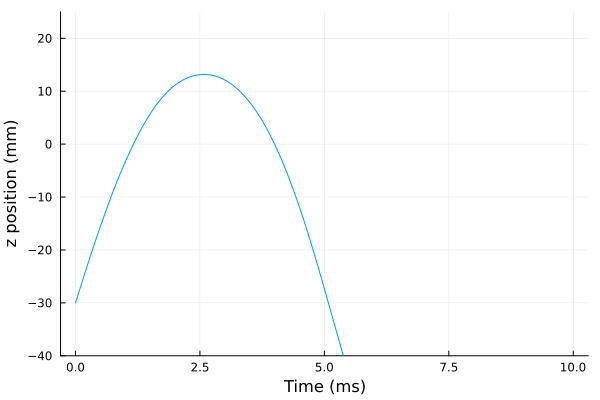

In [7502]:
plot(sol.t .* (1e3/Γ), (x_trajectories .+ y_trajectories) ./ √2,
    legend=nothing,
    xlabel="Time (ms)",
    ylabel="z position (mm)",
    ylim=(-40,25)
)

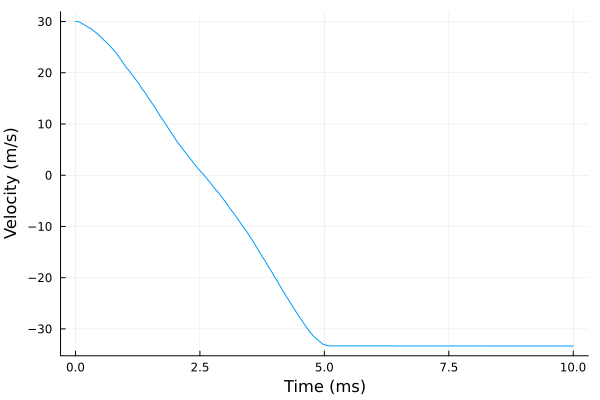

In [7508]:
plot(sol.t .* (1e3/Γ), (x_velocities .+ y_velocities) ./ √2,
    legend=nothing,
    xlabel="Time (ms)",
    ylabel="Velocity (m/s)"
)

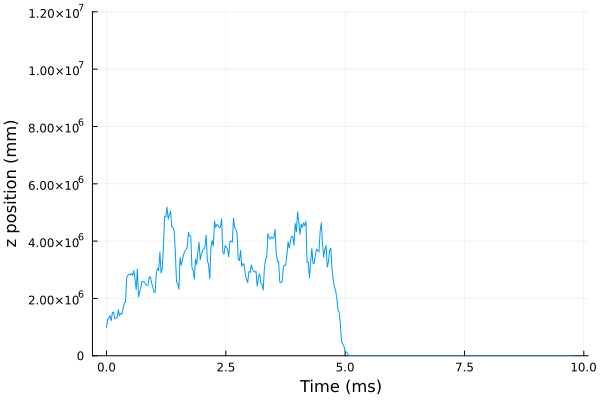

In [7509]:
moving_average(vs,n) = [sum(@view vs[i:(i+n-1)])/n for i in 1:(length(vs)-(n-1))]

plot(sol.t[1:end-9] .* (1e3/Γ), moving_average(Γ * excited_population, 10),
    legend=nothing,
    xlabel="Time (ms)",
    ylabel="z position (mm)",
    ylim=(0,1.2e7)
)

In [7511]:
prob.p.n_scatters ./ 5e-3

3.1994e6

In [7506]:
exp(-50/16) / exp(-100/16)

22.75989509352673

In [7507]:
exp(-72/16)

0.011108996538242306

### Run simulation for multiple particles in parallel

In [4990]:
@everywhere begin
    vs = 2:1:22
    const scan_params = (
        v = vs,
        )
end
;

In [4147]:
@everywhere function prob_func(prob, i, repeat)

    sim_params = prob.p.sim_params
    extra_data = prob.p.extra_data
    n_states = prob.p.n_states
    n_excited = prob.p.n_excited
    t_span = prob.tspan
    
    X_states, A_states = define_CaOH_states()
    states = [X_states; A_states[1:4]]
    d = tdms_between_states(states, states)
    
    lasers = define_lasers(
        states,
        sim_params.RF_frequency,
        sim_params.s1,
        sim_params.s2,
        sim_params.s3,
        sim_params.s4,
        sim_params.Δ1,
        sim_params.Δ2,
        sim_params.Δ3,
        sim_params.Δ4,
        sim_params.pol1_x,
        sim_params.pol2_x,
        sim_params.pol3_x,
        sim_params.pol4_x,
        sim_params.pol_imbalance,
        sim_params.s_imbalance,
        sim_params.retro_loss,
        sim_params.off_center,
        sim_params.pointing_error
    )

    # Define initial conditions for the molecule
    v = scan_params.v[i]
    r0 = [-0.02, -0.02, 0] / √2
    v0 = v .* [1, 1, 0] / √2
    particle = Particle()
    particle.r = r0 ./ (1/k)
    particle.v = v0 ./ (Γ/k)
    ψ₀ = zeros(ComplexF64, n_states)
    ψ₀[1] = 1.0
    
    p = schrodinger_stochastic(particle, states, lasers, d, ψ₀, m/(ħ*k^2/Γ), n_excited; sim_params=sim_params, extra_data=extra_data, λ=λ, Γ=Γ, update_H_and_∇H=update_H_and_∇H)
    callback = ContinuousCallback(condition_simple, SE_collapse_pol_always!, nothing, save_positions=(false,false))
    prob = ODEProblem(ψ_stochastic_potential!, p.ψ, t_span, p, callback=callback, reltol=5e-4, saveat=1000, maxiters=80000000)

    return prob
end
;

In [ ]:
n_molecules = length(vs)
ensemble_prob = EnsembleProblem(prob; prob_func=prob_func)
@time ensemble_sol = solve(ensemble_prob, DP5(), EnsembleDistributed(); trajectories=n_molecules)
;

LoadError: UndefVarError: `prob_func` not defined

In [ ]:
function captured(sol)
    xy_pos = (sol.u[end][n_states + n_excited + 1] + sol.u[end][n_states + n_excited + 2]) / √2 / k*1e3
    if real(xy_pos) > 10
        return false
    end
    return true
end

function capture_velocity(vs, ensemble_sol)
    max_idx = maximum(findall([captured(ensemble_sol[i]) for i ∈ eachindex(vs)]))
    return vs[max_idx]
end
;

In [ ]:
x_trajectories = Array{Vector{Float64}}(fill([],n_molecules))
y_trajectories = Array{Vector{Float64}}(fill([],n_molecules)) 
z_trajectories = Array{Vector{Float64}}(fill([],n_molecules))
x_velocities = Array{Vector{Float64}}(fill([],n_molecules))
y_velocities = Array{Vector{Float64}}(fill([],n_molecules))
z_velocities = Array{Vector{Float64}}(fill([],n_molecules))
photons_scattered = zeros(n_molecules)

times = Array{Vector{Float64}}(fill([],n_molecules))

for i ∈ 1:n_molecules
    sol_u = ensemble_sol[i].u
    sol_t = ensemble_sol[i].t
    
    x_trajectories[i] = [x_trajectories[i]; [real(u[n_states + n_excited + 1]) for u in sol_u] ./ k*1e3]
    y_trajectories[i] = [y_trajectories[i]; [real(u[n_states + n_excited + 2]) for u in sol_u] ./ k*1e3]
    z_trajectories[i] = [z_trajectories[i]; [real(u[n_states + n_excited + 3]) for u in sol_u] ./ k*1e3]
    
    x_velocities[i] = [x_velocities[i]; [real(u[n_states + n_excited + 4]) for u in sol_u] ./ (k/Γ)]
    y_velocities[i] = [y_velocities[i]; [real(u[n_states + n_excited + 5]) for u in sol_u] ./ (k/Γ)]
    z_velocities[i] = [z_velocities[i]; [real(u[n_states + n_excited + 6]) for u in sol_u] ./ (k/Γ)]
    
    photons_scattered[i] = ensemble_sol[i].prob.p.n_scatters
    
    times[i] = sol_t .* (1/Γ)
end

trajectories = [
    [[x[1],x[2],x[3]] for x ∈ zip(x_trajectories[i], y_trajectories[i], z_trajectories[i])] 
    for i ∈ 1:n_molecules
    ]
;

LoadError: UndefVarError: `ensemble_sol` not defined

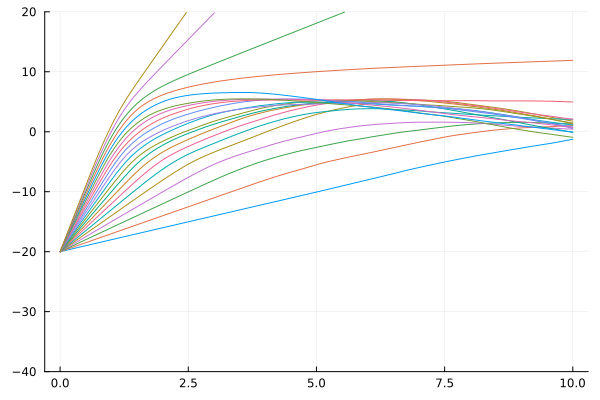

In [22]:
lim = 40
plot()
for i ∈ 1:n_molecules
    plot!(times[i] .* 1e3, (x_trajectories[i] .+ y_trajectories[i]) ./ √2, legend=nothing)
end
plot!(ylim=(-40,20))

In [23]:
Δ1s = (-4:0.2:0) .* Γ
Δ2s = (-4:0.2:0) .* Γ

capture_vs = zeros(Float64, length(Δ1s), length(Δ2s))
ensemble_sols = Dict()

for (i,Δ1) ∈ enumerate(Δ1s)
    for (j,Δ2) ∈ enumerate(Δ2s)
        
        # set detunings
        prob.p.sim_params.Δ1 = Δ1
        prob.p.sim_params.Δ2 = Δ2
        
        # solve the problem for a range of velocities
        n_molecules = length(vs)
        ensemble_prob = EnsembleProblem(prob; prob_func=prob_func)
        @time ensemble_sol = solve(ensemble_prob, DP5(), EnsembleDistributed(); trajectories=n_molecules)
        
        # calculate capture velocity
        capture_vs[i,j] = capture_velocity(vs, ensemble_sol)
        ensemble_sols[(Δ1,Δ2)] = ensemble_sol
    end
end

 84.206990 seconds (602.38 k allocations: 24.314 MiB, 0.02% gc time)
 85.860194 seconds (603.22 k allocations: 24.409 MiB)
 87.812146 seconds (608.28 k allocations: 24.597 MiB, 0.02% gc time)
 90.417420 seconds (610.23 k allocations: 24.723 MiB)
 97.874729 seconds (618.32 k allocations: 25.138 MiB, 0.02% gc time)
 99.891759 seconds (619.05 k allocations: 25.268 MiB, 0.02% gc time)
111.290194 seconds (624.26 k allocations: 25.653 MiB)
115.067271 seconds (639.46 k allocations: 26.186 MiB, 0.01% gc time)
127.411631 seconds (640.71 k allocations: 26.642 MiB)
126.746806 seconds (650.73 k allocations: 27.042 MiB, 0.01% gc time)
142.378006 seconds (661.18 k allocations: 27.518 MiB, 0.01% gc time)
136.910335 seconds (660.23 k allocations: 27.442 MiB)
143.526452 seconds (666.00 k allocations: 27.745 MiB, 0.01% gc time)
146.762426 seconds (666.07 k allocations: 27.775 MiB, 0.01% gc time)
142.626914 seconds (665.07 k allocations: 27.584 MiB)
138.961208 seconds (661.13 k allocations: 27.508 MiB, 0

In [65]:
findmax(capture_vs)

(19.0, CartesianIndex(3, 13))

In [68]:
Δ1s[3] / Γ

-3.5999999999999996

In [70]:
Δ1s[13] / Γ

-1.5999999999999999

In [327]:
capture_vs[end-5,end-5]

15.0

In [126]:
using LaTeXStrings

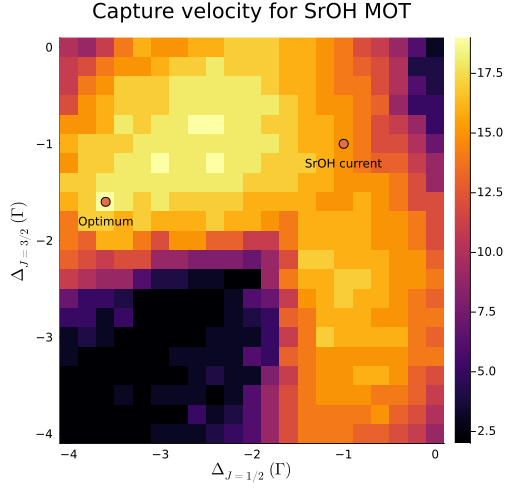

In [306]:
hm = heatmap(Δ1s ./ Γ, Δ2s ./ Γ, capture_vs')
plot!(
    title="Capture velocity for SrOH MOT",
    xlabel=L"Δ_{J=1/2}\,\,(Γ)",
    ylabel=L"Δ_{J=3/2}\,\,(Γ)",
    size=(520,500),
    xlim=(-4.1,0.1),
    ylim=(-4.1,0.1),
    right_margin=4*Plots.mm
)
scatter!([-1,-3.6], [-1,-1.6], markersize=5, markerfill=nothing, legend=nothing)
annotate!(-1, -1.2, text("SrOH current", 8, :black))
annotate!(-3.6, -1.8, text("Optimum", 8, :black))

In [87]:
scattered_photons = zeros(Float64, length(Δ1s), length(Δ2s))

for (i,Δ1) ∈ enumerate(Δ1s)
    for (j,Δ2) ∈ enumerate(Δ2s)
        scattered_photons[i,j] = ensemble_sols[(Δ1,Δ2)][9].prob.p.n_scatters
    end
end

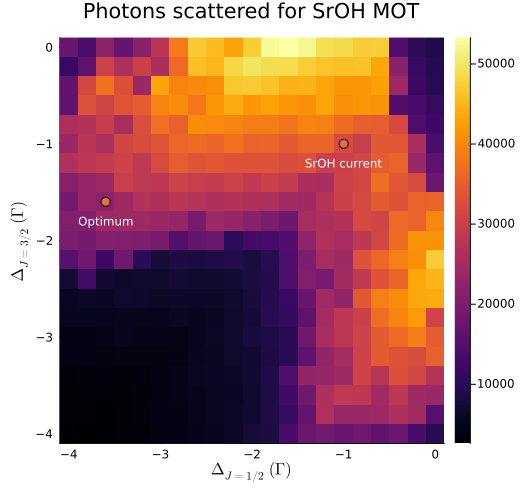

In [324]:
heatmap(Δ1s ./ Γ, Δ2s ./ Γ, scattered_photons')
plot!(
    title="Photons scattered for SrOH MOT",
    xlabel=L"Δ_{J=1/2}\,\,(Γ)",
    ylabel=L"Δ_{J=3/2}\,\,(Γ)",
    size=(520,500),
    xlim=(-4.1,0.1),
    ylim=(-4.1,0.1),
    right_margin=4*Plots.mm
)
scatter!([-1,-3.6], [-1,-1.6], markersize=5, markerfill=nothing, legend=nothing)
annotate!(-1, -1.2, text("SrOH current", 8, :white))
annotate!(-3.6, -1.8, text("Optimum", 8, :white))

In [342]:
capture_vs[end-3,end-3]

13.0

In [328]:
capture_vs[end-5,end-5]

15.0

In [337]:
capture_vs[end-18,end-8]

19.0

In [339]:
scattered_photons[end-5,end-5]

31871.0

In [340]:
scattered_photons[end-18,end-8]

21871.0